<a href="https://colab.research.google.com/github/ReidelVichot/LC_identification/blob/main/annual_Air_012725.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting the Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# -- Setting environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# -- Load county shapefiles
#dir = "/content/drive/MyDrive/Disertation/countyshp/"
#county = gpd.read_file(dir + "tl_2010_us_county00/tl_2010_us_county00.shp")
#county = county[["CNTYIDFP00", "geometry"]]

Mounted at /content/drive


In [2]:
dir = "/content/drive/MyDrive/Disertation/EPA_data/Summary/"

# -- Create pollution indicators
ind_temp = pd.DataFrame()
# -- Columns of interest
#cols = ["State", "County", "Year", "Median AQI"]

for year in range(1998, 2023):
  df = pd.read_csv(dir + f"annual_conc_by_monitor_{year}.csv", low_memory = False)
  #df = df[cols]
  ind_temp = pd.concat([ind_temp, df]).reset_index().drop(columns="index")

# -- Remove Canada
ind_temp = ind_temp[ind_temp["State Code"] != "CC"]
# -- Generate GEOID
ind_temp["GEOID"] = ind_temp["State Code"].astype(str).str.zfill(2) + ind_temp["County Code"].astype(str).str.zfill(3)
ind_temp["GEOID"] = ind_temp.GEOID.astype(str)

cols = ['GEOID', 'Parameter Name', "Parameter Code", "Site Num", "POC",
       'Sample Duration', 'Pollutant Standard', 'Metric Used',
       'Year', 'Units of Measure', 'Event Type', 'Observation Count',
       'Completeness Indicator', 'Valid Day Count',
       'Arithmetic Mean', 'Arithmetic Standard Dev']
ind_temp = ind_temp[cols]

# Remove cases in which events occurred
ind_temp = ind_temp[(ind_temp["Event Type"]=="No Events")|(ind_temp["Event Type"]=="Events Excluded")]
ind_temp.drop(columns=["Event Type"], inplace=True)
# Data is complete
ind_temp = ind_temp[ind_temp["Completeness Indicator"]=="Y"]
ind_temp = ind_temp.drop(columns=["Completeness Indicator"]).copy()

# Ozone Units of Measure is Parts per million
O3 = ind_temp[ind_temp["Parameter Name"]=="Ozone"]
O3 = O3[O3["Units of Measure"]=="Parts per million"]
O3 = O3[O3["Metric Used"]=='Daily maximum of 8-hour running average']

O3 = O3.groupby(["GEOID", "Year"]).mean(numeric_only=True).reset_index()
cols = ["GEOID", "Year", "Arithmetic Mean"]
O3 = O3[cols]
O3.columns = ["GEOID", "Year", "O3"]

CO = ind_temp[ind_temp["Parameter Name"]=="Carbon monoxide"]

CO = CO[CO["Metric Used"] == 'Obseved hourly values']
CO = CO[CO["Units of Measure"] == 'Parts per million']
CO = CO.groupby(["GEOID", "Year"]).mean(numeric_only=True).reset_index()
CO = CO[cols]
CO.columns = ["GEOID", "Year", "CO"]

In [3]:
NO2 = ind_temp[ind_temp["Parameter Name"]=="Nitrogen dioxide (NO2)"]
# NO2 is in Parts per billion
NO2 = NO2[NO2["Metric Used"]=="Observed values"]
NO2 = NO2[NO2["Units of Measure"]=="Parts per billion"]
NO2 = NO2.groupby(["GEOID", "Year"]).mean(numeric_only=True).reset_index()
NO2 = NO2[cols]
NO2.columns = ["GEOID", "Year", "NO2"]

In [4]:
SO2 = ind_temp[ind_temp["Parameter Name"]=="Sulfur dioxide"]
SO2 = SO2[SO2["Metric Used"]=="Observed Values"]
SO2 = SO2[SO2["Units of Measure"]=="Parts per billion"]
SO2 = SO2[SO2["Sample Duration"]=="1 HOUR"]
SO2 = SO2.groupby(["GEOID", "Year"]).mean(numeric_only=True).reset_index()
SO2 = SO2[cols]
SO2.columns = ["GEOID", "Year", "SO2"]

In [5]:
PM25 = ind_temp[ind_temp["Parameter Name"]=="PM2.5 - Local Conditions"]
# Metric Used -> Daily Mean
PM25 = PM25[PM25["Metric Used"]=="Daily Mean"]
PM25 = PM25[PM25["Sample Duration"]=="24 HOUR"]
PM25 = PM25[PM25["Pollutant Standard"] == "PM25 24-hour 1997"]
PM25 = PM25[PM25["Units of Measure"] == "Micrograms/cubic meter (LC)"]
PM25 = PM25.groupby(["GEOID", "Year"]).mean(numeric_only=True).reset_index()
PM25 = PM25[cols]
PM25.columns = ["GEOID", "Year", "PM25"]

In [6]:
PM10_LC = ind_temp[ind_temp["Parameter Name"]=="PM10 - LC"]
PM10_LC = PM10_LC[PM10_LC["Units of Measure"] == "Micrograms/cubic meter (LC)"]
PM10_LC = PM10_LC[PM10_LC["Sample Duration"] == "24 HOUR"]
PM10_LC = PM10_LC[PM10_LC["Metric Used"] == "Observed Values"]
PM10_LC = PM10_LC.groupby(["GEOID", "Year"]).mean(numeric_only=True).reset_index()
PM10_LC = PM10_LC[cols]
PM10_LC.columns = ["GEOID", "Year", "PM10_LC"]

In [12]:
PM10_25C = ind_temp[ind_temp["Parameter Name"]=="PM10 Total 0-10um STP"]


PM10_25C = PM10_25C[PM10_25C["Units of Measure"] == "Micrograms/cubic meter (25 C)"]
PM10_25C = PM10_25C[PM10_25C["Sample Duration"] == "24 HOUR"]
PM10_25C = PM10_25C[PM10_25C["Metric Used"] == "Daily Mean"]

PM10_25C = PM10_25C.groupby(["GEOID", "Year"]).mean(numeric_only=True).reset_index()
PM10_25C = PM10_25C[cols]
PM10_25C.columns = ["GEOID", "Year", "PM10_25C"]

In [15]:
# Treatmen Counties
treatments = ["18063","37179","34003","25027","13151","48329","27003","48135","42071","51107","42077","06065","34007"]

06065 18063 25027 27003 34003 34007 42071 42077 

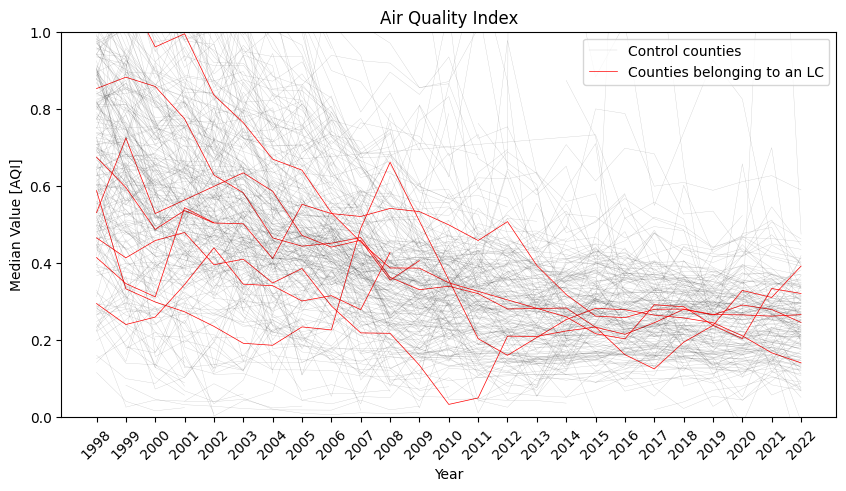

In [18]:
# Plotting trends
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in CO.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = CO[CO.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["CO"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["CO"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = CO[CO.GEOID == i]
      ax.plot(df.Year, df["CO"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = CO[CO.GEOID == i]
      ax.plot(df.Year, df["CO"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Median Value [AQI]")
ax.set_ylim(0,1)
ax.legend()
ax.set_title("Air Quality Index")

fig.show()


Caption: Air Quality Index (AQI) by County. Red lines represent counties that fulfill the treatment criteria, and gray lines represent counties that conform the donor pool to construct a synthetic control.

06065 18063 25027 27003 34003 34007 42071 42077 51107 13151 37179 48135 

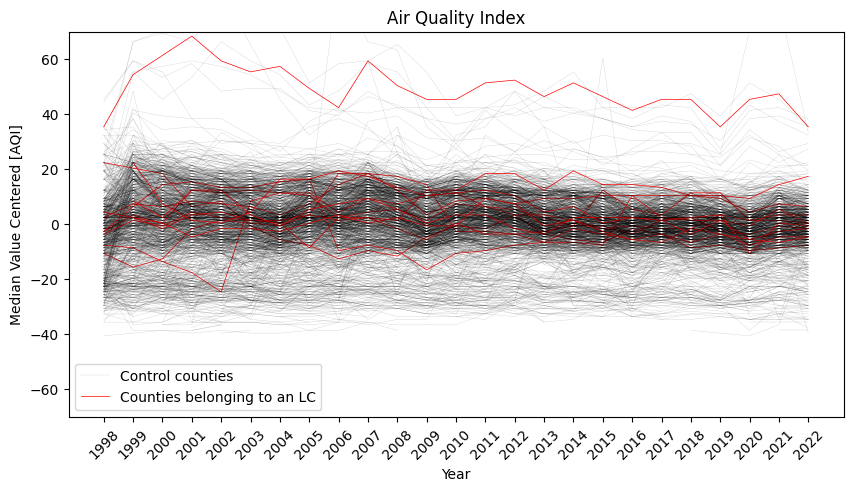

In [ ]:
aqi["AQI_cent"] = aqi['Median AQI'] - aqi["Median AQI"].mean()

# Plotting trends
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in aqi.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = aqi[aqi.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["AQI_cent"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["AQI_cent"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = aqi[aqi.GEOID == i]
      ax.plot(df.Year, df["AQI_cent"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = aqi[aqi.GEOID == i]
      ax.plot(df.Year, df["AQI_cent"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Median Value Centered [AQI]")
ax.set_ylim(-70,70)
ax.legend()
ax.set_title("Air Quality Index")

fig.show()

06065 18063 25027 27003 34003 34007 42071 42077 51107 13151 37179 48135 

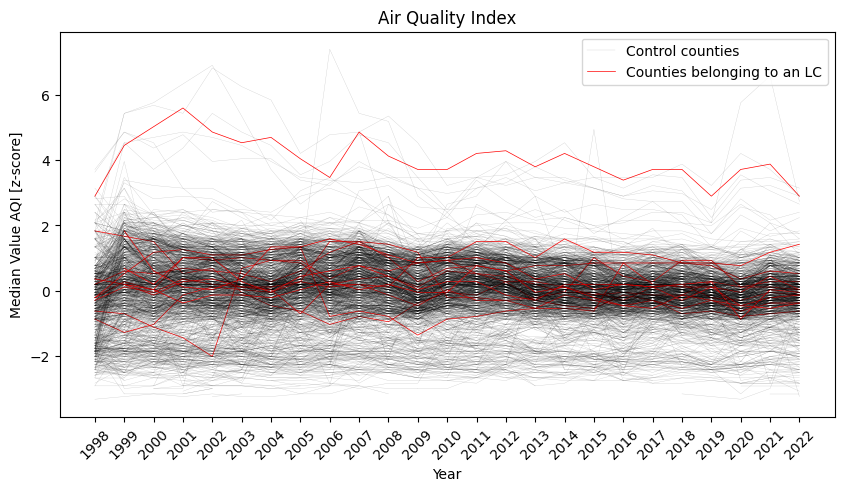

In [ ]:
aqi["z-score"] = (aqi['Median AQI'] - aqi["Median AQI"].mean())/aqi["Median AQI"].std()

# Plotting trends
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in aqi.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = aqi[aqi.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["z-score"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["z-score"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = aqi[aqi.GEOID == i]
      ax.plot(df.Year, df["z-score"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = aqi[aqi.GEOID == i]
      ax.plot(df.Year, df["z-score"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Median Value AQI [z-score]")
ax.legend()
ax.set_title("Air Quality Index")

fig.show()

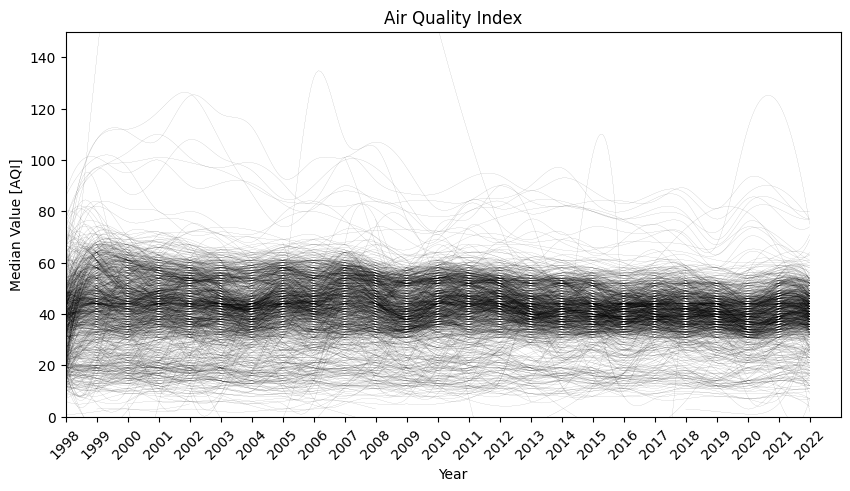

In [ ]:
# Plotting trends
from scipy.interpolate import make_interp_spline, BSpline

fig, ax = plt.subplots(figsize=(10,5))

for i in aqi.GEOID.unique():
  df = aqi[aqi.GEOID == i]
  import numpy as np
  # Sample data
  x = np.array(df.Year)
  y = np.array(df["Median AQI"])

  # Check if enough data points are available for cubic spline interpolation
  if len(x) >= 4:
    # Create a smoother curve using interpolation
    x_smooth = np.linspace(x.min(), x.max(), 300)
    spl = make_interp_spline(x, y, k=3)  # k=3 for cubic spline
    y_smooth = spl(x_smooth)

    # Plot the original data and the smooth curve
    ax.plot(x_smooth, y_smooth, linewidth=0.05, color="k")
  else:
    pass

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Median Value [AQI]")
ax.set_ylim(0,150)
ax.set_xlim(1998,2023)
ax.set_title("Air Quality Index")

fig.show()

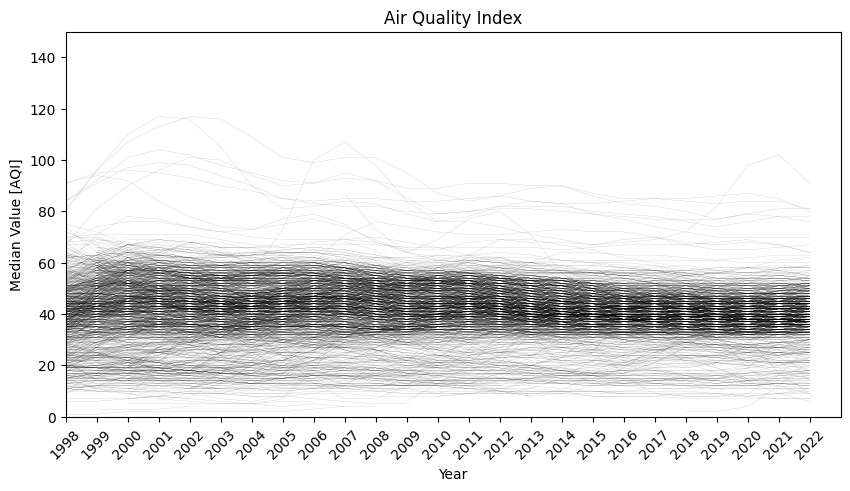

In [ ]:
# Plotting trends
from scipy.ndimage import gaussian_filter1d

fig, ax = plt.subplots(figsize=(10,5))

for i in aqi.GEOID.unique():
  df = aqi[aqi.GEOID == i]
  import numpy as np
  # Sample data
  x = np.array(df.Year)
  y = np.array(df["Median AQI"])

  # Check if enough data points are available for cubic spline interpolation
  if len(x) >= 4:
    # Apply Gaussian smoothing
    y_smooth = gaussian_filter1d(y, sigma=1)  # Adjust sigma for smoothness

    # Plot the original data and the smooth curve
    # Instead of using x_smooth, use the original x values for plotting
    ax.plot(x, y_smooth, linewidth=0.05, color="k")
  else:
    pass

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Median Value [AQI]")
ax.set_ylim(0,150)
ax.set_xlim(1998,2023)
ax.set_title("Air Quality Index")

fig.show()